In [7]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [8]:
import scipy.io
fname='dataset_liver_bmodes_steatosis_assessment_IJCARS.mat'
mat = scipy.io.loadmat(fname)


This cell works!

<ipython-input-9-3b66f20ad45d>:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_class = np.squeeze(classes).astype(int)
<ipython-input-9-3b66f20ad45d>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_steatosis_grade = np.array([float(fat[0]) for fat in fat_percentages])


Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 42s 42s/step - classification_output_accuracy: 0.3636 - classification_output_loss: 1.2604 - grade_output_loss: 1394.8276 - grade_output_mae: 25.5212 - loss: 1396.0880 - val_classification_output_accuracy: 0.7273 - val_classification_output_loss: 8.4631 - val_grade_output_loss: 569.6487 - val_grade_output_mae: 21.6598 - val_loss: 578.1119
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 618ms/step - classification_output_accuracy: 0.6818 - classification_output_loss: 10.4028 - grade_output_loss: 813.9294 - grade_output_mae: 26.8095 - loss: 824.3321 - val_classification_output_accuracy: 0.7273 - val_classification_output_loss: 9.3056 - val_grade_output_loss: 865.8872 - val_grade_output_mae: 24.0503 - val_loss: 875.1927
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step - classification_output_accuracy: 0.6818 - classification_output_loss: 11.3272 - grade_output_loss: 1170.9062 - grade_output_mae: 31.5078 - loss: 1182.2334 - val_classification_output_accuracy: 0.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - classification_output_accuracy: 0.7273 - classification_output_loss: 2.7815 - grade_output_loss: 462.4709 - grade_output_mae: 19.8794 - loss: 465.2524
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
Test AUC for Fatty Liver Detection: 0.958
Mean Absolute Error for Steatosis Grading: 19.879
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Patient 1: Fatty Liver
Steatosis Grade for Patient 1: Grade 2 (36.98% fat)
Patient 2: Fatty Liver
Steatosis Grade for Patient 2: Grade 1 (27.84% fat)
Patient 3: Fatty Liver
Steatosis Grade for Patient 3: Grade 2 (35.38% fat)
Patient 4: Fatty Liver
Steatosis Grade for Patient 4: Grade 1 (28.44% fat)
Patient 5: Fatty Liver
Steatosis Grade for Patient 5: Grade 1 (25.16% fat)
Patient 6: Fatty Liver
Steatosis Grade for Patient 6: Grade 2 (50.40% fat)
Patient 7: Fatty Liver
Steatosis Grade for Patient 7: Grade 2 (38.52% fat)
Patient 8: Fatty Liver
Steatosis Grade for Patient 8: Grade 2 (44.21% fat)
Patient 9: Fatty Liver
Steatosis Grade f

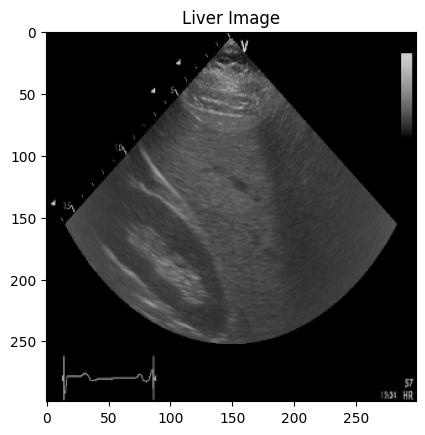

In [9]:
import numpy as np
import scipy.io
import cv2
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import h5py

# Load the .mat file
mat = scipy.io.loadmat('dataset_liver_bmodes_steatosis_assessment_IJCARS.mat')
data_array = mat['data']

# Extract fields from the structured array
patient_ids = data_array['id'][0]
classes = data_array['class'][0]
fat_percentages = data_array['fat'][0]
image_arrays = data_array['images'][0]

# Function to assign liver steatosis grade based on fat percentage
def assign_steatosis_grade(fat_percentage):
    if fat_percentage < 5:
        return 0
    elif 5 <= fat_percentage <= 33:
        return 1
    elif 34 <= fat_percentage <= 66:
        return 2
    else:
        return 3

# Apply the grading function to the fat percentages
y_grade = np.array([assign_steatosis_grade(fat) for fat in fat_percentages])

# Image preprocessing function
def preprocess_image(img):
    img_resized = cv2.resize(img, (299, 299))
    img_rgb = np.stack([img_resized]*3, axis=-1)
    return img_rgb / 255.0

# Preprocess all images into a format suitable for training
processed_images = [
    [preprocess_image(img) for img in patient]
    for patient in image_arrays
]

# Stack processed images for the dataset
X = np.array([np.mean(patient, axis=0) for patient in processed_images])
y_class = np.squeeze(classes).astype(int)
y_steatosis_grade = np.array([float(fat[0]) for fat in fat_percentages])

# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train_class, y_test_class, y_train_grade, y_test_grade = train_test_split(
    X, y_class, y_steatosis_grade, test_size=0.2, random_state=42
)

# Build the model for transfer learning using Inception-ResNet-V2
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
x = base_model.output
x = Flatten()(x)

# Fatty liver classification output (binary)
classification_output = Dense(1, activation='sigmoid', name='classification_output')(x)

# Steatosis grade regression output (continuous)
grade_output = Dense(1, activation='linear', name='grade_output')(x)

# Define the model with two outputs
model = Model(inputs=base_model.input, outputs=[classification_output, grade_output])

# Freeze base model layers and compile the model
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(),
              loss={'classification_output': 'binary_crossentropy', 'grade_output': 'mean_squared_error'},
              metrics={'classification_output': 'accuracy', 'grade_output': 'mae'})

# Train the model
history = model.fit(X_train, {'classification_output': y_train_class, 'grade_output': y_train_grade},
                    epochs=10, batch_size=256, validation_data=(X_test, {'classification_output': y_test_class, 'grade_output': y_test_grade}))

# Save the model as an .h5 file
model.save("model.h5")

# Evaluate the model on test data
test_loss, test_classification_loss, test_grade_loss, test_classification_acc, test_grade_mae = model.evaluate(
    X_test, {'classification_output': y_test_class, 'grade_output': y_test_grade}
)

# Predict on test data
y_pred_class, y_pred_grade = model.predict(X_test)

# Evaluate classification performance (AUC)
test_auc = roc_auc_score(y_test_class, y_pred_class)
print(f'Test AUC for Fatty Liver Detection: {test_auc:.3f}')

# Evaluate regression performance for steatosis grading (MAE)
print(f'Mean Absolute Error for Steatosis Grading: {test_grade_mae:.3f}')

inference_predictions = model.predict(X_test)
for i in range(len(inference_predictions[0])):
    classification = inference_predictions[0][i][0]  # Get the classification probability (0 or 1)
    grade = inference_predictions[1][i][0]  # Get the steatosis grade prediction (continuous)

    # Determine if it is Fatty Liver  or Healthy Liver based on classification
    if classification > 0.5:
        print(f"Patient {i+1}: Fatty Liver")

        # Determine the grade based on the fat percentage (max value from inference_predictions[1])
        if grade < 5:
            steatosis_grade = 0  # No steatosis
        elif 5 <= grade <= 33:
            steatosis_grade = 1  # Mild steatosis
        elif 34 <= grade <= 66:
            steatosis_grade = 2  # Moderate steatosis
        else:
            steatosis_grade = 3  # Severe steatosis

        print(f"Steatosis Grade for Patient {i+1}: Grade {steatosis_grade} ({grade:.2f}% fat)")
    else:
        print(f"Patient {i+1}: Healthy Liver")
#atlases = np.mean(X, axis=0)
plt.imshow(X_test[6])
plt.title('Liver Image')
plt.show()
